# Emotion Recognition from Speech

In [16]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [17]:
paths = []
labels = []

valid_audio_exts = ['.wav', '.mp3', '.flac', '.ogg']

for dirname, _, filenames in os.walk("/Volumes/Personal/ML_Code Alpha/Emotion-Recognition-from-Speech/Tesson Emotion Dataset"):
    for filename in filenames:
        if any(filename.lower().endswith(ext) for ext in valid_audio_exts):
            paths.append(os.path.join(dirname, filename))
            label = filename.split('_')[-1]
            label = label.split('.')[0]
            labels.append(label.lower())
    if len(paths) == 2800: 
        break

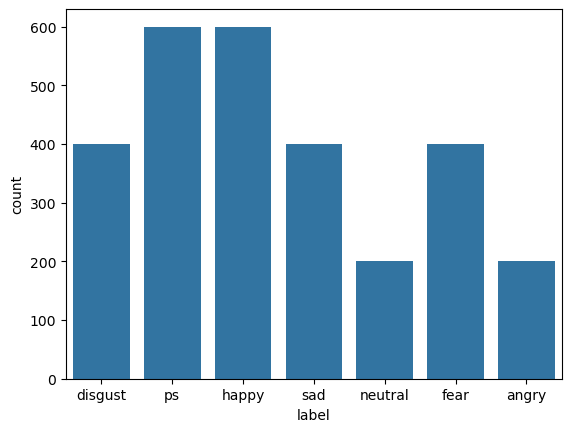

In [18]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels

sns.countplot(data=df, x='label')
plt.show()


# Exploratory Data Analysis: Waveplot and Spectrogram

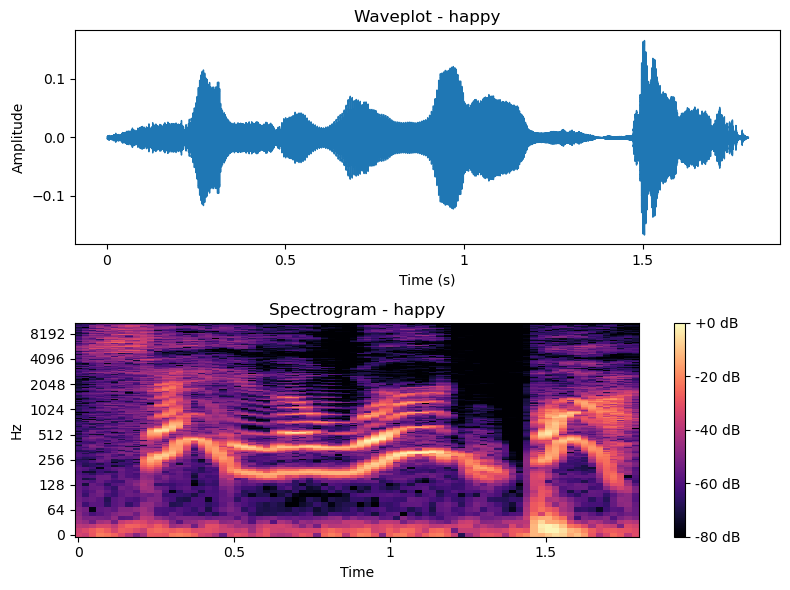

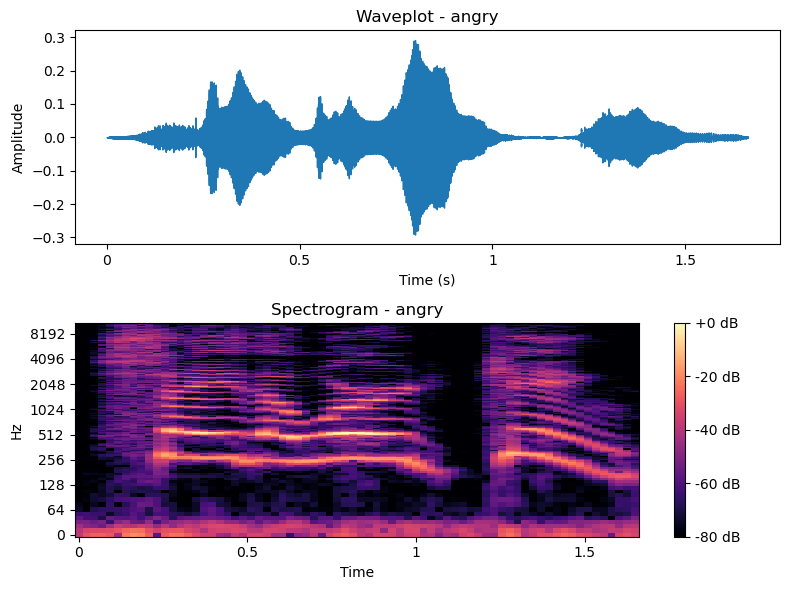

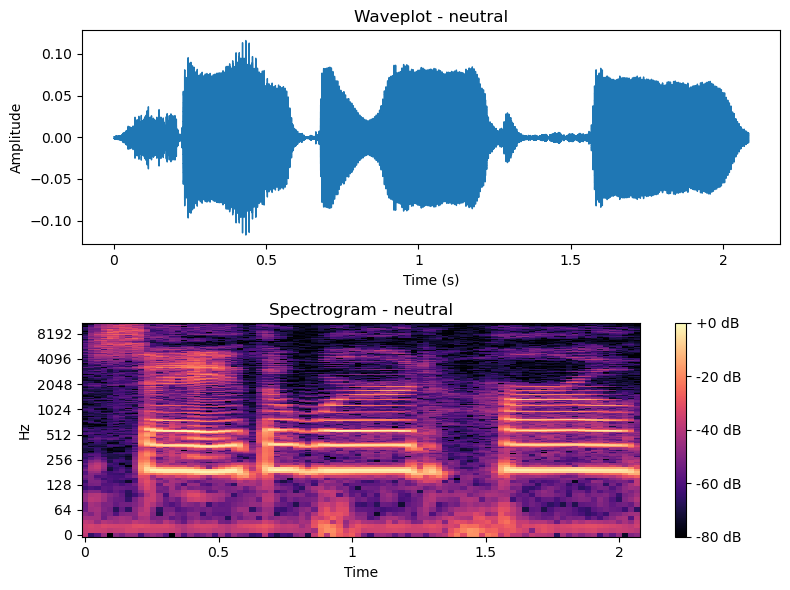

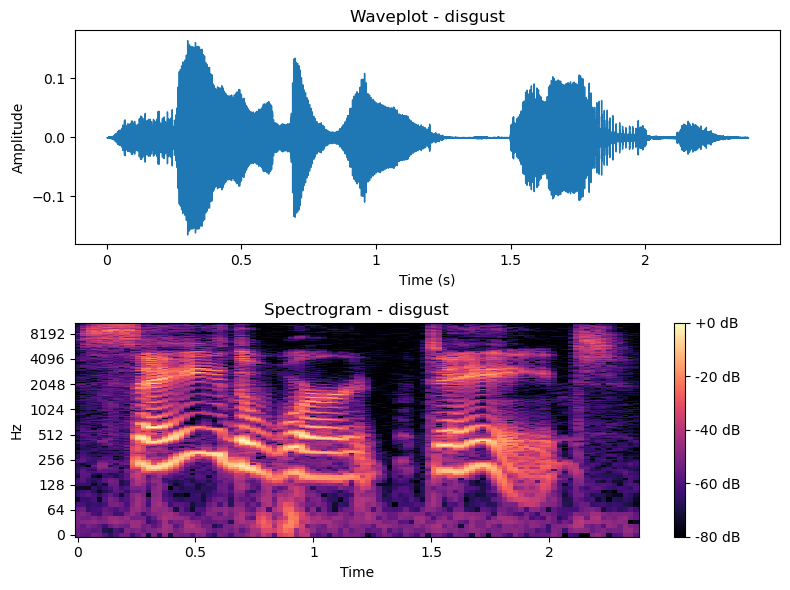

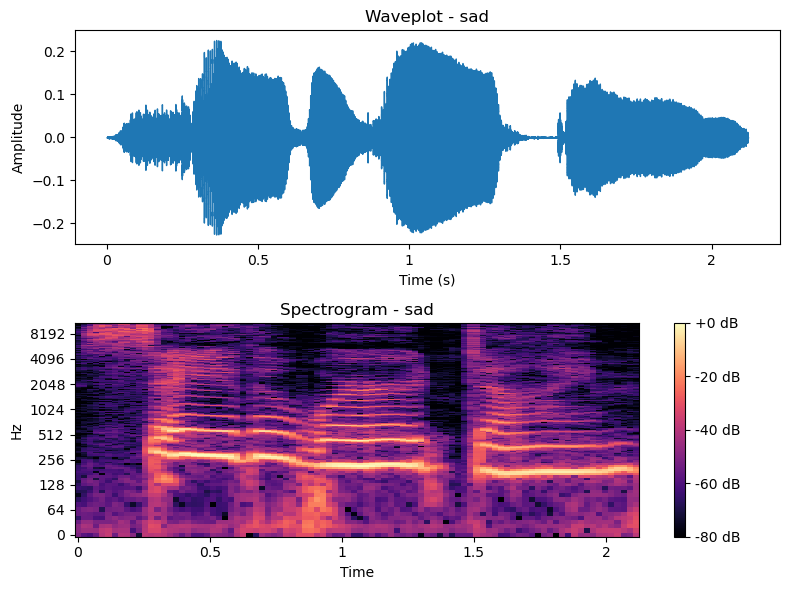

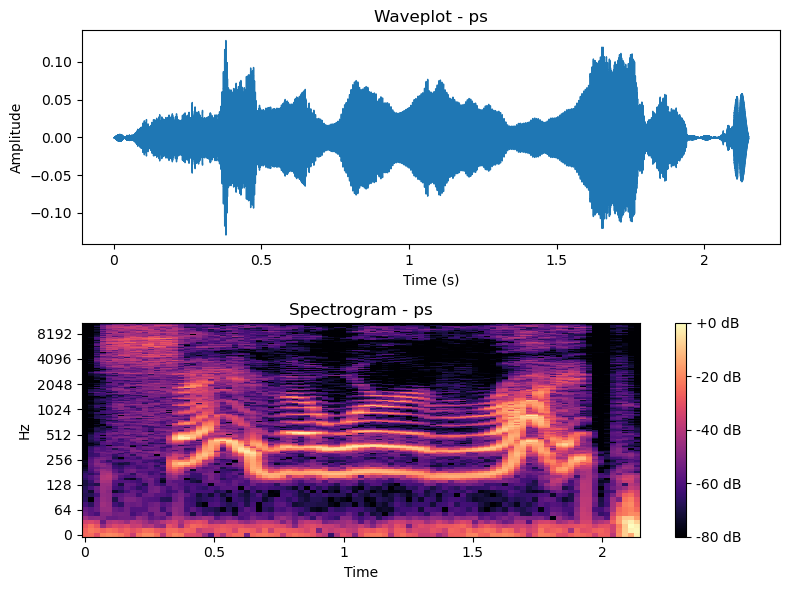

In [19]:
def plot_waveplot_and_spectrogram(filename, emotion):
    data, sr = librosa.load(filename)
    plt.figure(figsize=(8, 6)) 

    plt.subplot(2, 1, 1)
    librosa.display.waveshow(data, sr=sr)
    plt.title(f'Waveplot - {emotion}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    plt.subplot(2, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.title(f'Spectrogram - {emotion}')
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout() 
    plt.show()


emotions = ['happy', 'angry', 'neutral', 'disgust', 'sad', 'ps' ] 
for emotion in emotions:
    path = np.array(df['speech'][df['label'] == emotion])[0]
    plot_waveplot_and_spectrogram(path, emotion)
    display(Audio(path))


In [20]:
def extract_mfcc(filename):
    try:
        y, sr = librosa.load(filename, duration=3, offset=0.5)
        mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
        return mfcc
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return None


X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))
X_mfcc = X_mfcc.dropna()  # Dropping the entries that MFCC extraction failed
X = np.array([x for x in X_mfcc])
X = np.expand_dims(X, -1)

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df.loc[X_mfcc.index, ['label']]).toarray()


In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
from keras.models import Model, load_model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Add
from keras.optimizers import Adam

input_layer = Input(shape=(X.shape[1], 1))

conv1 = Conv1D(128, 5, padding='same', activation='relu')(input_layer)
conv1 = BatchNormalization()(conv1)
conv1 = MaxPooling1D(pool_size=2)(conv1)
conv1 = Dropout(0.3)(conv1)

res1 = Conv1D(128, 1, padding='same', strides=2)(input_layer)
res1 = Add()([conv1, res1])

conv2 = Conv1D(64, 5, padding='same', activation='relu')(res1)
conv2 = BatchNormalization()(conv2)
conv2 = MaxPooling1D(pool_size=2)(conv2)
conv2 = Dropout(0.3)(conv2)

res2 = Conv1D(64, 1, padding='same', strides=2)(res1)
res2 = Add()([conv2, res2])

conv3 = Conv1D(32, 5, padding='same', activation='relu')(res2)
conv3 = BatchNormalization()(conv3)
conv3 = MaxPooling1D(pool_size=2)(conv3)
conv3 = Dropout(0.3)(conv3)

res3 = Conv1D(32, 1, padding='same', strides=2)(res2)
res3 = Add()([conv3, res3])

flat = Flatten()(res3)
dense1 = Dense(128, activation='relu')(flat)
dense1 = Dropout(0.3)(dense1)

output_layer = Dense(7, activation='softmax')(dense1)


model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


model.summary()

2024-08-28 23:17:44.312522: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-08-28 23:17:44.312540: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-08-28 23:17:44.312544: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-08-28 23:17:44.312567: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-28 23:17:44.312580: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40, 1)]              0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 40, 128)              768       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 40, 128)              512       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 20, 128)              0         ['batch_normalization[0][0

In [23]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50


2024-08-28 23:17:44.960700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


68/70 [============================>.] - ETA: 0s - loss: 13.5822 - accuracy: 0.3244

2024-08-28 23:17:46.443543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - 2s 18ms/step - loss: 13.3712 - accuracy: 0.3304 - val_loss: 3.8022 - val_accuracy: 0.5714
Epoch 2/50
70/70 [==============================] - 1s 14ms/step - loss: 3.5268 - accuracy: 0.6625 - val_loss: 1.0258 - val_accuracy: 0.8196
Epoch 3/50
70/70 [==============================] - 1s 13ms/step - loss: 2.2607 - accuracy: 0.7871 - val_loss: 0.8889 - val_accuracy: 0.8464
Epoch 4/50
70/70 [==============================] - 1s 14ms/step - loss: 0.8720 - accuracy: 0.8996 - val_loss: 0.4099 - val_accuracy: 0.9214
Epoch 5/50
70/70 [==============================] - 1s 14ms/step - loss: 0.4286 - accuracy: 0.9353 - val_loss: 0.1649 - val_accuracy: 0.9625
Epoch 6/50
70/70 [==============================] - 1s 13ms/step - loss: 0.5340 - accuracy: 0.9290 - val_loss: 0.1433 - val_accuracy: 0.9696
Epoch 7/50
70/70 [==============================] - 1s 13ms/step - loss: 0.2930 - accuracy: 0.9594 - val_loss: 0.2157 - val_accuracy: 0.9589
Epoch 8/50
70/70 [=====

In [24]:
train_acc = history.history['accuracy'][-1]
print(f"Training accuracy: {train_acc}")

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")


Training accuracy: 0.996874988079071
18/18 [==============================] - 0s 9ms/step - loss: 0.1574 - accuracy: 0.9929
Test accuracy: 0.9928571581840515


In [25]:
model.save('emotion.h5')

loaded_model = load_model('emotion.h5')


 1/18 [>.............................] - ETA: 3s

2024-08-28 23:18:33.751174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 5ms/step
Confusion Matrix:
[[ 43   0   0   0   0   0   0]
 [  0  67   0   0   0   0   0]
 [  0   0  73   0   0   0   0]
 [  2   0   0 138   0   0   0]
 [  0   0   0   0  37   0   0]
 [  0   0   0   2   0 124   0]
 [  0   0   0   0   0   0  74]]


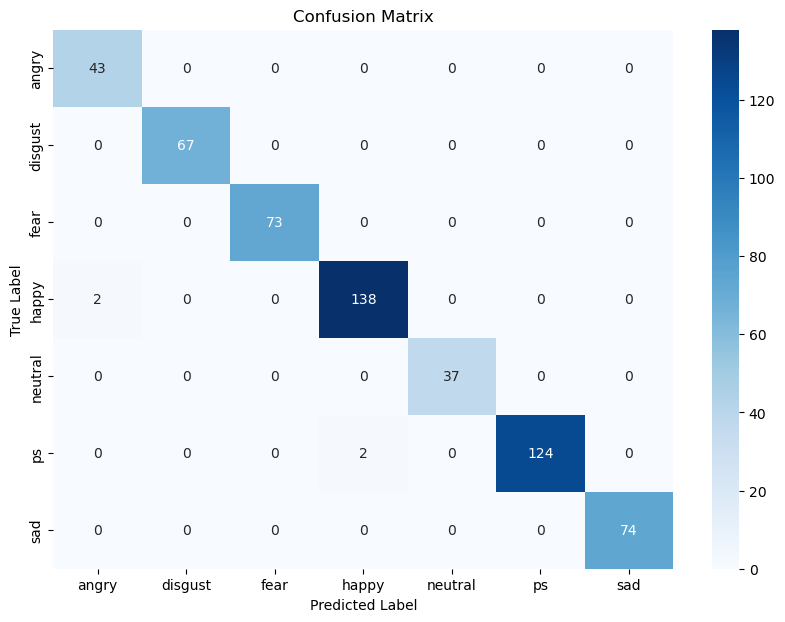

Classification Report:
              precision    recall  f1-score   support

       angry       0.96      1.00      0.98        43
     disgust       1.00      1.00      1.00        67
        fear       1.00      1.00      1.00        73
       happy       0.99      0.99      0.99       140
     neutral       1.00      1.00      1.00        37
          ps       1.00      0.98      0.99       126
         sad       1.00      1.00      1.00        74

    accuracy                           0.99       560
   macro avg       0.99      1.00      0.99       560
weighted avg       0.99      0.99      0.99       560



In [26]:
y_pred = loaded_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=enc.categories_[0], yticklabels=enc.categories_[0])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=enc.categories_[0]))


In [28]:
import random


random_index = random.randint(0, len(df) - 1)
random_path = df['speech'].iloc[random_index]
random_label = df['label'].iloc[random_index]

random_mfcc = extract_mfcc(random_path)
if random_mfcc is not None:
    random_mfcc = np.expand_dims(random_mfcc, axis=0)
    random_mfcc = np.expand_dims(random_mfcc, axis=-1)

    predicted_label = loaded_model.predict(random_mfcc)
    predicted_label = enc.inverse_transform(predicted_label)[0][0]

    print(f"Actual Label: {random_label}")
    print(f"Predicted Label: {predicted_label}")


    display(Audio(random_path))
else:
    print(f"Error processing the random sample: {random_path}")


1/1 [==============================] - 0s 12ms/step
Actual Label: fear
Predicted Label: fear


In [34]:
import random


random_index = random.randint(0, len(df) - 1)
random_path = df['speech'].iloc[random_index]
random_label = df['label'].iloc[random_index]

random_mfcc = extract_mfcc(random_path)
if random_mfcc is not None:
    random_mfcc = np.expand_dims(random_mfcc, axis=0)
    random_mfcc = np.expand_dims(random_mfcc, axis=-1)

    predicted_label = loaded_model.predict(random_mfcc)
    predicted_label = enc.inverse_transform(predicted_label)[0][0]

    print(f"Actual Label: {random_label}")
    print(f"Predicted Label: {predicted_label}")


    display(Audio(random_path))
else:
    print(f"Error processing the random sample: {random_path}")


1/1 [==============================] - 0s 12ms/step
Actual Label: angry
Predicted Label: angry
